In [ ]:
import os
import csv
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.sparse import lil_matrix, linalg, csgraph
import networkx as nx

In [2]:
save_dir = "./assets/assignment2/"
ques = ["Q1/", "Q2/", "Q3/", "Q4/"]
save_dirs = [save_dir + q for q in ques]
for save_dir in save_dirs:
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

## Question 2

Q2. Consider the email communication dataset [linked here](https://snap.stanford.edu/data/email-Eu-core.html). Use it as an undirected network. Nodes are tagged with departments. Consider each department as a set and calculate both its density ($\rho$) and conductance ($\phi$). Find out the sparsest cut as given by the second eigenvector of the normalized Laplacian and report its conductance ($\phi_{\text{cut}}$). Also report the histogram of departments in the sparsest cut.

#### Solution:

**Loading the Data:**

- The dataset consists of two files:
  - `email-Eu-core.txt`: Contains edges (email communications between individuals).
  - `email-Eu-core-department-labels.txt`: Contains department labels for each individual.
- We read both files and store them in appropriate data structures.


In [3]:
email_dir = "./data/email-Eu-core/"
edge_file = email_dir + "email-Eu-core.txt"
label_file = email_dir + "email-Eu-core-department-labels.txt"

# Read the edge list and labels
edges = pd.read_csv(edge_file, sep=" ", header=None, names=["id_1", "id_2"], dtype=int)
edges = [(min(row[0], row[1]), max(row[0], row[1])) for row in edges.values]
edges.sort(key=lambda x: (x[0], x[1]))  # sort edges by id_1 and id_2
labels = pd.read_csv(label_file, sep=" ", header=None, names=["id", "label"], dtype=int)
labels = labels["label"].values
print("Number of edges extracted =", len(edges))

# Removing self-loops
edges = [edge for edge in edges if edge[0] != edge[1]]
print("Number of edges after removing self-loops =", len(edges))

# Removing multi-edges
edges = list(set(edges))
print("Number of edges after removing multi-edges =", len(edges))

Number of edges extracted = 25571
Number of edges after removing self-loops = 24929
Number of edges after removing multi-edges = 16064


In [4]:
num_members = len(labels)
num_departments = len(set(labels))
print(f"Number of members: {num_members}")
print(f"Number of departments: {num_departments}")
dept_masks = {}
for i in range(num_departments):
    dept_masks[i] = np.zeros(num_members, dtype=bool)
for i in range(num_members):
    dept_masks[labels[i]][i] = True

Number of members: 1005
Number of departments: 42


In [5]:
adj_matrix = lil_matrix((num_members, num_members), dtype=np.int8)
for id_1, id_2 in tqdm(edges, total=len(edges)):
    adj_matrix[id_1, id_2] = 1
    adj_matrix[id_2, id_1] = 1
adj_matrix = adj_matrix.tocsr()
print(f"Adjacency matrix shape: {adj_matrix.shape}")

# Calculate the degree of each node
degrees = np.array(adj_matrix.sum(axis=1)).flatten()

  0%|          | 0/16064 [00:00<?, ?it/s]

100%|██████████| 16064/16064 [00:00<00:00, 75074.71it/s]

Adjacency matrix shape: (1005, 1005)


#### Sparsest Cut Computation
##### Step 1: Compute Normalized Laplacian
We use the normalized Laplacian matrix:
$$
L_{\text{norm}} = I - D^{-\frac{1}{2}} A D^{-\frac{1}{2}}
$$
where:
- $A$ is the adjacency matrix,
- $D$ is the diagonal degree matrix.

##### Step 2: Find the Second Eigenvector
- We compute the smallest two eigenvalues and eigenvectors of $L_{\text{norm}}$.
- The second eigenvector (Fiedler vector) is used to find a partition of the nodes.

##### Step 3: Sweep Cut to Find Best Conductance
- We sort nodes based on the Fiedler vector.
- We iterate through different cuts, computing conductance at each step.
- The best cut (minimizing conductance) is selected as the **sparsest cut**.


In [6]:
def calculate_density(adj_matrix, mask=None):
    if mask is None:
        mask = np.ones(adj_matrix.shape[0], dtype=bool)
    num_nodes = mask.sum()
    masked_matrix = adj_matrix[mask][:, mask]
    num_edges = masked_matrix.sum() / 2
    density = num_edges / num_nodes if num_nodes > 0 else 0.0
    return density

def calculate_conductance(adj_matrix, degrees, mask=None):
    if mask is None:
        raise ValueError("mask cannot be None for conductance calculation.")
    num_nodes = np.sum(mask)
    if num_nodes == 0:
        return 0.0
    cut_edges = adj_matrix[mask][:, ~mask].sum()
    vol_s = np.sum(degrees[mask])
    vol_s_complement = np.sum(degrees[~mask])
    conductance = cut_edges / min(vol_s, vol_s_complement) if min(vol_s, vol_s_complement) > 0 else 0.0
    return conductance

def calculate_sparsest_cut(adj_matrix, degrees):
    # using Spectral clustering to find the sparsest cut
    print("Calculating the sparsest cut...")
    num_members = adj_matrix.shape[0]
    laplacian = csgraph.laplacian(adj_matrix, normed=True)  # Normalized Laplacian
    eigenvalues, eigenvectors = linalg.eigsh(laplacian, k=2, which='SM')
    print("Eigenvalues: ", np.round(eigenvalues, 4))
    second_smallest_eigenvector = np.real(eigenvectors[:, 1])
    sorted_indices = np.argsort(second_smallest_eigenvector)
    best_conductance = float('inf')
    best_cut_idx = None
    for i in range(1, len(sorted_indices)):
        cut_mask = np.zeros(num_members, dtype=bool)
        cut_mask[sorted_indices[:i]] = True
        conductance = calculate_conductance(adj_matrix, degrees, cut_mask)
        # print(f"Iteration {i}: Conductance = {conductance}")
        if conductance < best_conductance:
            best_conductance = conductance
            best_cut_idx = i
            # print(f"New best conductance found: {best_conductance} at index {best_cut_idx}")
    cut_mask = np.zeros(num_members, dtype=bool)
    cut_mask[sorted_indices[:best_cut_idx]] = True
    complement_mask = ~cut_mask
    # print("Sparsest cut calculated.")
    return cut_mask, complement_mask, best_conductance

def calculate_histogram(adj_matrix, labels, departments, mask=None):
    if mask is None:
        mask = np.ones(adj_matrix.shape[0], dtype=bool)
    cut_labels = labels[mask]
    label_counts = Counter(cut_labels)
    histogram = np.zeros(len(departments), dtype=int)
    for label, count in label_counts.items():
        histogram[label] = count
    return histogram, label_counts

In [7]:
# Calculate density and conductance for each department
densities = []
conductances = []
for i in range(num_departments):
    mask = dept_masks[i]
    density = calculate_density(adj_matrix, mask)
    conductance = calculate_conductance(adj_matrix, degrees, mask)
    densities.append(density)
    conductances.append(conductance)

department_df = pd.DataFrame({
    "Department": range(num_departments),
    "Density": densities,
    "Conductance": conductances
})
department_df.to_csv(save_dirs[1] + "department_density_conductance.csv", index=False)

print("Department-wise Density and Conductance:")
display(department_df)

Department-wise Density and Conductance:


,Department,Density,Conductance
0,0,5.346939,0.557806
1,1,5.092308,0.594859
2,2,2.400000,0.781818
3,3,2.666667,0.785235
4,4,6.834862,0.559041
5,5,5.111111,0.753351
6,6,0.678571,0.906404
7,7,8.490196,0.440930
8,8,4.368421,0.718644
9,9,2.718750,0.729814


In [8]:
# Calculate the sparsest cut and its conductance of the largest connected component
G = nx.from_scipy_sparse_array(adj_matrix)
lcc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(lcc_nodes).copy()
adj_matrix_lcc = nx.to_scipy_sparse_array(G_lcc, format='csr')
print(f"Number of nodes in the largest connected component: {len(lcc_nodes)}")
degrees_lcc = np.array(adj_matrix_lcc.sum(axis=1)).flatten()
labels_lcc_list = labels[list(lcc_nodes)]

cut_mask, complement_mask, best_conductance = calculate_sparsest_cut(adj_matrix_lcc, degrees_lcc)
np.save(save_dirs[1] + "sparsest_cut_mask.npy", cut_mask)

print(f"Conductance of the sparsest cut: {best_conductance:.4f}")
print(f"Partition sizes: {np.sum(cut_mask)}, {np.sum(complement_mask)}")

Number of nodes in the largest connected component: 986
Calculating the sparsest cut...
Eigenvalues:  [-0.      0.2121]
Conductance of the sparsest cut: 0.2708
Partition sizes: 82, 904


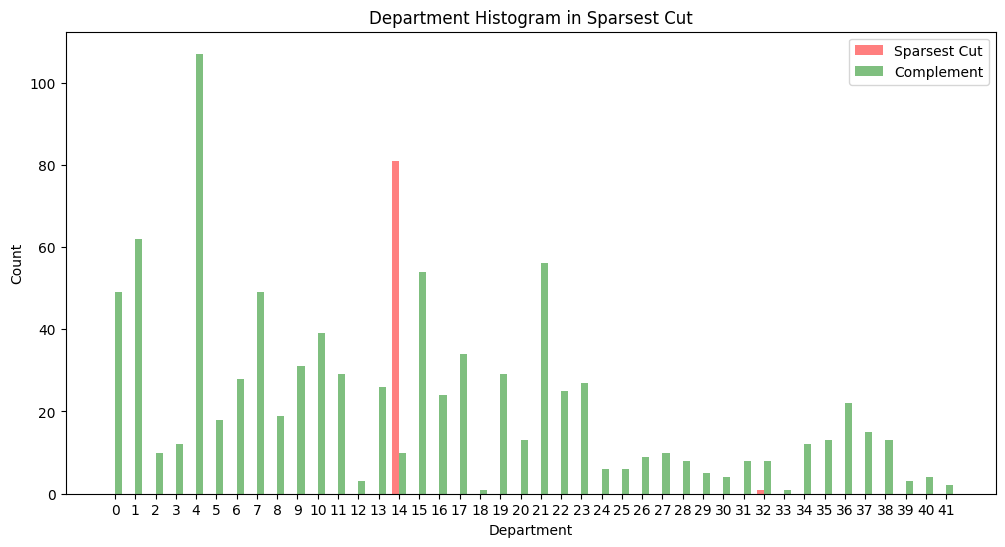

In [9]:
sparse_cut_dept_histogram, sparse_cut_label_counts = calculate_histogram(adj_matrix_lcc, labels_lcc_list, range(num_departments), cut_mask)
complement_mask_histogram, complement_label_counts = calculate_histogram(adj_matrix_lcc, labels_lcc_list, range(num_departments), complement_mask)

plt.figure(figsize=(12, 6))
bar_width = 0.35
indices = np.arange(num_departments)

plt.bar(indices, sparse_cut_dept_histogram, bar_width, color='red', alpha=0.5, label='Sparsest Cut')
plt.bar(indices + bar_width, complement_mask_histogram, bar_width, color='green', alpha=0.5, label='Complement')

plt.xlabel("Department")
plt.ylabel("Count")
plt.title("Department Histogram in Sparsest Cut")
plt.xticks(indices + bar_width / 2, range(num_departments))
plt.legend()
plt.savefig(save_dirs[1] + "sparsest_cut_histogram.png", dpi=300)
plt.show()